In [ ]:
#Pixelib Implementation
!pip3 install imgaug
!pip3 install pixellib --upgrade
!pip3 install tensorflow


Requirement already up-to-date: pixellib in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Download weight for model.... on the dataset... used
!gdown https://drive.google.com/uc?id=190yK1KLzLwWsO9Mjy5kX2EhThUrH-jK0

Downloading...
From: https://drive.google.com/uc?id=190yK1KLzLwWsO9Mjy5kX2EhThUrH-jK0
To: /content/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5
166MB [00:01, 115MB/s] 


In [ ]:
#Download Images
!gdown https://drive.google.com/uc?id=1X9kh5JCzyVmnxySvf5xDdZjuHBaYQKhL
!gdown https://drive.google.com/uc?id=1BcJPibpQsYWfP6cBuuvH0goXI3Z6Bnui

Downloading...
From: https://drive.google.com/uc?id=1X9kh5JCzyVmnxySvf5xDdZjuHBaYQKhL
To: /content/fg_woman.png
100% 254k/254k [00:00<00:00, 57.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BcJPibpQsYWfP6cBuuvH0goXI3Z6Bnui
To: /content/bg_woman.png
100% 441k/441k [00:00<00:00, 34.8MB/s]


In [ ]:
#Load model - change bg
import pixellib
from pixellib.tune_bg import alter_bg


change_bg = alter_bg()
change_bg.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")



uint8
<class 'numpy.ndarray'>
(1050, 700, 3)


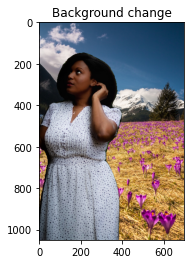

In [ ]:
#Change background
output = change_bg.change_bg_img(f_image_path = "./fg_woman.png", b_image_path = "./bg_woman.png")
print(output.dtype)
print(type(output))
print(output.shape)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.title('Background change')
plt.imshow(output)
plt.show()


uint8
<class 'numpy.ndarray'>
(1050, 700, 3)


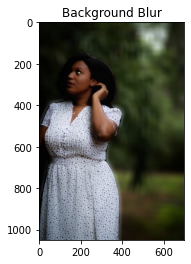

In [ ]:
#Blur Background
output = change_bg.blur_bg("./fg_woman.png", moderate = True)
print(output.dtype)
print(type(output))
print(output.shape)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.title('Background Blur')
plt.imshow(output)
plt.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // estamos esperando a que la promesa se cumpla basicamente esta en modo Block
      await new Promise((resolve) => capture.onclick = resolve);
      console.log('salio de aqui')
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();#obtengo el ultimo.....
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

ReferenceError: change_bg is not defined


In [ ]:
#modifiy their method
def change_bg_img(f_image_path,b_image_path, output_image_name = None, verbose = None):
  if verbose is not None:
    print("processing image......")

  seg_image = change_bg.segmentAsPascalvoc(f_image_path)
  
  ori_img = cv2.imread(f_image_path)
  
  bg_img = cv2.imread(b_image_path)
  w, h, _ = ori_img.shape
  bg_img = cv2.resize(bg_img, (h,w))

  result = np.where(seg_image[1], ori_img, bg_img)
  if output_image_name is not None:
    cv2.imwrite(output_image_name, result)

  return result

In [ ]:
#Change background on video feed not possible on colabs...
capture = cv2.VideoCapture(0)
while True:
  ret, frame = capture.read()#cojes del media stream y pasarlo a un nd.array y usarlo para le metodo
  output = change_bg.blur_frame(frame, extreme = True)
  cv2.imshow("frame", output)
  if  cv2.waitKey(25) & 0xff == ord('q'):
      break